In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#Just to push

In [4]:
def drawLines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 90, 100, apertureSize=3) 
    lines = cv2.HoughLinesP(
                    edges, #described above
                    1, #1 pixel resolution parameter
                    np.pi/180, # 1 degree resolution parameter
                    10, #min number of intersections/votes
                    minLineLength=10,
                    maxLineGap=60,
            ) # detect lines
    try:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            slope = (y2-y1)/(x2-x1)
            print(str(slope))
    except TypeError:
        pass
    
    return img


In [ ]:
img = cv2.imread('rov_pool.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
edges = cv2.Canny(gray, 106, 107, apertureSize=3) # detect edges, gray is image in grayscale, 50 and 150 represent 2 images that have been threshholded at 2 different levels, apertureSize controls how much light the image gets and how exposed it is
lines = cv2.HoughLinesP(
                edges, #described above
                1, #1 pixel resolution parameter
                np.pi/180, # 1 degree resolution parameter
                60, #min number of intersections/votes
                minLineLength=475,
                maxLineGap=100,
        ) # detect lines

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    slope = (y2-y1)/(x2-x1)
    print(str(slope))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
import cv2
import numpy as np

video = cv2.VideoCapture('AUV_Vid.mkv')

fps = int(video.get(cv2.CAP_PROP_FPS))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_file = 'output_video.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_file, fourcc, 30, (width, height))

ret, frame = video.read()
count = 0
frequency = 1

while ret:
    if count % frequency == 0:
        processed_frame = drawLines(frame)
        output_video.write(processed_frame)

    count += 1
    ret, frame = video.read()

video.release()
output_video.release()

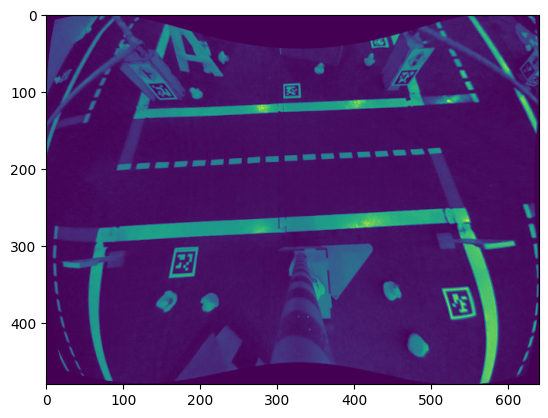

In [7]:
from dt_apriltags import Detector
import cv2
import numpy as np


cameraMatrix = np.array([ 1060.71, 0, 960, 0, 1060.71, 540, 0, 0, 1]).reshape((3,3))

camera_params = ( cameraMatrix[0,0], cameraMatrix[1,1], cameraMatrix[0,2], cameraMatrix[1,2] )


video = cv2.VideoCapture('AprilTagTest.mkv')

fps = int(video.get(cv2.CAP_PROP_FPS))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_file = 'output_video.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_file, fourcc, 30, (width, height))

ret, frame = video.read()
count = 0
frequency = 1


while ret:
    if count % frequency == 0:
        frame = cv2.imread(frame, cv2.IMREAD_GRAYSCALE)



        at_detector = Detector(families='tag36h11', #controls what it is supposed to detect
                       nthreads=1, #controls the number of threads used in the detection
                       quad_decimate=1.0, #controls to what scale the image is lowered in resolution
                       quad_sigma=0.0, #blur applied to the image to reduce noise
                       refine_edges=1, #attempts to redefine the edges of the tag boundaries
                       decode_sharpening=0.25, #controls how much the image is sharpened after the tags are discovered
                       debug=0) # no debugging information will be produced

        tags = at_detector.detect(frame, estimate_tag_pose=False, camera_params=None, tag_size=None)

        color_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

        for tag in tags:
            for idx in range(len(tag.corners)):
                cv2.line(color_frame, tuple(tag.corners[idx - 1, :].astype(int)), tuple(tag.corners[idx, :].astype(int)), (0, 255, 0))

            cv2.putText(color_frame, str(tag.tag_id),
                        org=(tag.corners[0, 0].astype(int) + 10, tag.corners[0, 1].astype(int) + 10),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.8,
                        color=(0, 0, 255))


        output_video.write(color_frame)

    count += 1
    ret, frame = video.read()

video.release()
output_video.release()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dt_apriltags import Detector
import matplotlib.cm as cm
from lane_detection import *
from lane_following import *

video = cv2.VideoCapture('AUV_Vid.mkv')

width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_file = 'output_video_center.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_file, fourcc, 30, (width, height))

i = 0
ret = True
while ret:
    slopeSet = set() 
    i += 1
    ret, frame = video.read()
    if(i%1 == 0 and i > 90):
        lines = detect_lines(frame, 50, 90, 3,150,10)
        try:
            lanes = detect_lanes(lines)
            pickedLane = pick_lane(lanes)
            frame = draw_Single_lane(frame, pickedLane, (255, 0, 0))
            frame = draw_lines(frame, lines,(0, 255, 0))
            center_intercept, center_slope = get_lane_center(pickedLane)
            xPoint = pickedLane[0][2]
            yPoint = pickedLane[0][3]
            cv2.line(frame, (int(center_intercept), 1080), (int(xPoint), int(yPoint)), (0,0,255), 3)
        except:
            pass
        
    
        output_video.write(frame)



video.release()
output_video.release()